### A.1 scinder le fichier de façon à ce que BD[i] corresponde aux données de l’action i, puis calculer ER, qui est une liste de 12 éléments, chacun représentant le taux de rendement attendu de chaque action.


In [1]:
# contenu de excel "Actif","Dates","Ouverture","Max","Min","Fermeture","Volume"
import numpy as np
import numpy.linalg as cm
import pandas as pd
import glob
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

file_list = glob.glob("actions/*.xlsm")
BD = [pd.read_excel(file, engine="openpyxl") for file in file_list]

# ER est un vecteur de taille 12 qui contient les rendements moyens des 12 actions
ER = np.ones((12, 1))
for j in range(12):
    bd = BD[j]
    St = [
        (bd.iloc[i, 3] + bd.iloc[i, 4]) / 2 for i in range(255)
    ]  # St est le prix moyen de chaque action
    Rt = [
        (St[i + 1] / St[i]) - 1 for i in range(254)
    ]  # Rt est le rendement de chaque action
    ER[j] = np.mean(Rt)  # ER[j] est le rendement moyen de l'action j

### A.2 Calculer dans la fonction de la frontière efficiente les paramètres

La formule est la suivante : $$m_{\sigma} = \frac{b}{a} + \sqrt{\sigma^2 - \frac{1}{a}} \times norm$$
où $$m_{\sigma}$$ représente le rendement espéré maximal correspondant à la valeur de 𝜎


In [2]:
# SIGMA est la matrice de covariance des rendements des 12 actions
SIGMA = np.ones((12, 12))

for i in range(12):
    for j in range(12):
        bdi = BD[i]
        Sti = [(bdi.iloc[k, 3] + bdi.iloc[k, 4]) / 2 for k in range(255)]
        Rti = [
            (Sti[k + 1] / Sti[k]) - 1 for k in range(254)
        ]  # Rti est les rendements de l'action i
        RtiC = np.array(Rti) - ER[i]  # RtiC est le rendement de l'action i centré

        bdj = BD[j]
        Stj = [(bdj.iloc[k, 3] + bdj.iloc[k, 4]) / 2 for k in range(255)]
        Rtj = [
            Stj[k + 1] / Stj[k] - 1 for k in range(254)
        ]  # Rtj est le rendement de l'action j
        RtjC = np.array(Rtj) - ER[j]

        SIGMA[i, j] = np.mean(RtiC * RtjC)


print("Détérminant de sigma :", cm.det(SIGMA))
assert cm.det(SIGMA) != 0
sigmainv = cm.inv(SIGMA)

vect1 = np.ones((12, 1))
vect1T = vect1.T

a = vect1T @ sigmainv @ vect1
a = a[0][0]
print("a: ", a)

b = vect1T @ sigmainv @ ER
b = b[0][0]
print("b: ", b)

Vect = ER - (b / a) * vect1
norm2 = Vect.T @ sigmainv @ Vect
norm = np.sqrt(norm2)[0][0]
print("Norm: ", norm)
valsigma = np.linspace(1 / a, 2 / a, 100)

Détérminant de sigma : 1.7470455596539675e-48
a:  22541.52841897661
b:  -4.842703763275818
Norm:  0.25708574674943396


### A.5. Répéter la simulation avec des poids générés aléatoirement, puis sélectionner les poids optimaux (critère de filtrage : $\sigma \le \sigma_{\max}$)


In [3]:
# frontière efficiente
def FE(a, b, sigma, norm):
    y = b / a + np.sqrt(sigma**2 - 1 / a) * norm
    return y


# frontière non efficiente
def FNE(a, b, sigma, norm):
    y = b / a - np.sqrt(sigma**2 - 1 / a) * norm
    return y


# constante
def cste(a, b):
    y = b / a
    return y

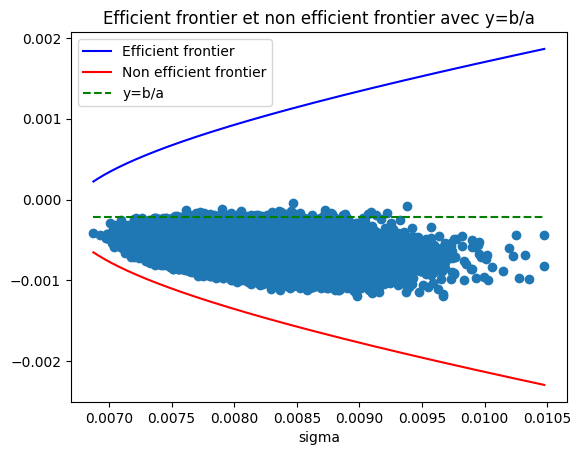

In [4]:
Axe1 = []
Axe2 = []
NS = 200000  # nombre de simulations

for _ in range(NS):
    # générer un vecteur de poids aléatoires
    x = [npr.uniform() for _ in range(12)]  # uniforme sur [0, 1]
    x = np.array(x)  # convertir en tableau numpy
    s = np.sum(x)  # somme des poids

    #  pas égal à 0
    if s == 0:
        x[0] = 1  # si la somme des poids est nulle, on met le premier poids à 1
    else:
        x = x / s  # normaliser les poids

    # calculer le rendement et le variance
    var = x.T @ SIGMA @ x
    sig = np.sqrt(var)
    esp = x.T @ ER
    Axe1.append(sig)
    Axe2.append(esp)

axesigma = np.linspace(min(Axe1), max(Axe1), 200)
axeFE = [FE(a, b, sigma, norm) for sigma in axesigma]
axeFNE = [FNE(a, b, sigma, norm) for sigma in axesigma]
axeCste = [cste(a, b) for sigma in axesigma]

plt.scatter(Axe1, Axe2)
plt.title("Efficient frontier et non efficient frontier avec y=b/a")
plt.plot(axesigma, axeFE, label="Efficient frontier", color="blue")
plt.plot(axesigma, axeFNE, label="Non efficient frontier", color="red")
plt.plot(axesigma, axeCste, label="y=b/a", color="green", linestyle="--")
plt.legend()
plt.xlabel("sigma")
plt.show()

In [ ]:
def get_x_opt(Sigmax, NS):
    Espmax = -(10**10)  # initialisation le rendement maximal

    # initialisation du vecteur de poids optimal
    x_opt = np.array([1 for _ in range(12)])

    for _ in range(NS):
        # générer un vecteur de poids aléatoires
        x = [npr.uniform() for _ in range(12)]  # uniforme sur [0, 1]
        x = np.array(x)  # convertir en tableau numpy
        s = np.sum(x)  # somme des poids

        #  pas égal à 0
        if s == 0:
            x[0] = 1  # si la somme des poids est nulle, on met le premier poids à 1
        else:
            x = x / s  # normaliser les poids

        # calculer le rendement et le variance
        var = x.T @ SIGMA @ x
        sig = np.sqrt(var)
        esp = x.T @ np.squeeze(ER)

        # vérifier si la contrainte de risque est satisfaite
        if sig <= Sigmax:
            # vérifier si le rendement est supérieur à l'ancien rendement maximal
            if esp > Espmax:
                Espmax = esp  # mettre à jour le rendement maximal
                x_opt = x  # mettre à jour le vecteur de poids optimal

    return x_opt, Espmax

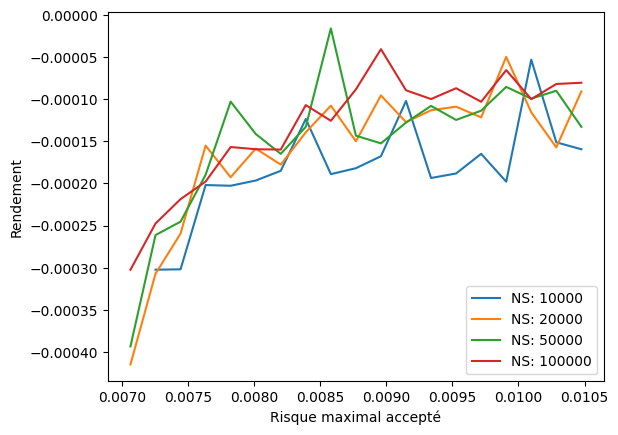

Poids optimal:  [0.03376196 0.00344358 0.0135634  0.01572506 0.10080686 0.239833
 0.10877872 0.18135227 0.00748702 0.21720353 0.01883621 0.05920838]


In [ ]:
sig_mag_axe = np.linspace(min(Axe1), max(Axe1), 20)
sims = [10000, 20000, 50000, 100000]



sim_res = []
x_opt = np.zeros(12)
esp_max = -(10**10)

for sim in sims:
    rendements = []
    for i in range(len(sig_mag_axe)):
        x, esp = get_x_opt(sig_mag_axe[i], sim)
        if esp == -(10**10):
            esp = None
        if esp is not None and sim == 100000 and esp > esp_max:
            esp_max = esp
            x_opt = x
        rendements.append(esp)
    sim_res.append(rendements)

for i in range(len(sims)):
    plt.plot(sig_mag_axe, sim_res[i], label="NS: " + str(sims[i]))
plt.legend()
plt.xlabel("Risque maximal accepté")
plt.ylabel("Rendement")
plt.show()


print("Poids optimal: ", x_opt)

### B.1 Extraction des données de l'année 2019

### BD2019[i] représente la liste des prix de l'action i en 2019.


In [31]:
# genere un BD qui contient seulement les données de 2019
BD2019 = []

for df in BD:
    # convertir la colonne de date en format datetime

    df.iloc[:, 1] = pd.to_datetime(
        df.iloc[:, 1], format="%d/%m/%Y"
    )  # iloc[:, 1] choisi la colonne de date
    # filtrer les données de 2019
    df_2019 = df[df.iloc[:, 1].dt.year == 2019]
    BD2019.append(df_2019)

# vérification
for i, df in enumerate(BD2019):  # enumerate() retourne un objet énumérant
    print(f"File {i+1} - Number of rows: {len(df)}")
    print(df.head())

File 1 - Number of rows: 245
     FR0000120404 2018-01-02 00:00:00  43.21  43.51  42.85  43.48   966332
254  FR0000120404          2019-01-02  36.94  36.94  36.04  36.60   562162
255  FR0000120404          2019-01-03  36.39  36.55  36.00  36.00   800687
256  FR0000120404          2019-01-04  36.41  37.03  36.17  36.84  1074737
257  FR0000120404          2019-01-07  37.02  37.02  36.44  37.00   554260
258  FR0000120404          2019-01-08  37.10  37.46  36.87  37.09   720341
File 2 - Number of rows: 245
     FR0000120628 2018-01-02 00:00:00    24.8  24.805   24.47   24.76  \
254  FR0000120628          2019-01-02  18.620  18.816  18.428  18.806   
255  FR0000120628          2019-01-03  18.626  18.950  18.612  18.650   
256  FR0000120628          2019-01-04  18.792  19.294  18.718  19.236   
257  FR0000120628          2019-01-07  19.282  19.380  19.038  19.150   
258  FR0000120628          2019-01-08  19.212  19.474  19.158  19.222   

      5193046  
254   8028529  
255   6583413  
256  

###


### B.2 Donner un capital initial de 10^5, appliquer x_opt comme pourcentage initial, ajuster la position à chaque instant, puis calculer \(C_t\) pour chaque valeur de \(t\).


In [ ]:
def cal_theta_cash_fee(C, x_opt, St, k, old_theta):
    theta = np.array(
        [int(C * x_opt[i] / St[i]) for i in range(len(St))]
    )  # theta est le nombre d'actions initiales, c'est-à-dire le nombre initial d'actions achetées pour chaque action, capital total * pourcentage / prix
    fee = np.abs(theta - old_theta).T @ St * k  # frais de transaction
    cash = (
        C - theta.T @ St - fee
    )  # cash est le capital restant après l'achat des actions
    C_available = C
    while cash < 0:
        C_available -= 1  # On essaie d'utiliser de moins en moins de capital pour acheter des actions,
        # jusqu'à ce que le capital restant soit positif
        theta = np.array([int(C_available * x_opt[i] / St[i]) for i in range(len(St))])
        fee = np.abs(theta - old_theta).T @ St * k
        cash = C - theta.T @ St - fee
    return theta, cash, fee


def test_strategy_with_k(C, x_opt, S, k, freq=1):
    S0 = np.array(
        [S[i][0] for i in range(12)]
    )  # S0 contient les prix de chaque action le premier jour de 2019
    theta, cash, fee = cal_theta_cash_fee(C, x_opt, S0, k, np.zeros(12, dtype=int))
    Cs = [C - fee]
    fees = [fee]

    # deuxième jour à la fin de 2019
    for t in range(1, len(S[0])):  # len(BD2019[0])est le nombre de jours en 2019
        St = np.array(
            [S[i][t] for i in range(12)]
        )  # St contient les prix de chaque action le jour t de 2019
        C = cash + theta.T @ St
        Cs.append(C)
        if t % freq != 0:
            fees.append(0)
        else:
            # cash est le capital à l'instant t-1, thetaT est la quantité détenue à l'instant t-1, St est le prix de l'action à l'instant t
            theta, cash, fee = cal_theta_cash_fee(C, x_opt, St, k, theta)
            fees.append(fee)

    return Cs, fees

[np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.

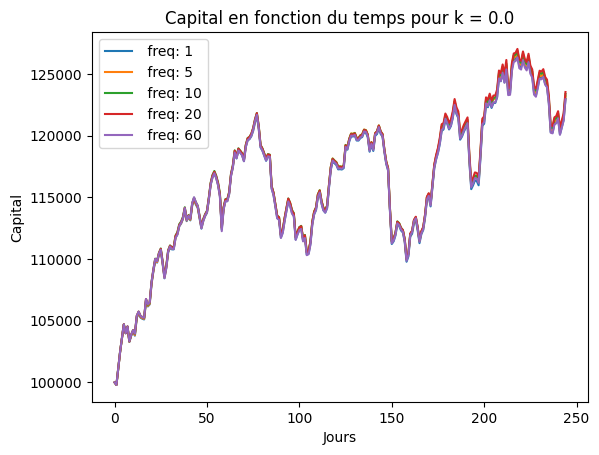

[np.float64(989.8265100000003), np.float64(11.444175), np.float64(6.602175), np.float64(10.836450000000003), np.float64(10.440525000000001), np.float64(11.343425), np.float64(6.171), np.float64(7.022625000000001), np.float64(9.974655000000002), np.float64(5.543625), np.float64(9.38675), np.float64(5.731699999999998), np.float64(2.141775), np.float64(7.739725), np.float64(5.388925), np.float64(3.103125), np.float64(5.8696), np.float64(6.437525000000001), np.float64(7.138275), np.float64(4.323875), np.float64(23.285549999999997), np.float64(4.756724999999999), np.float64(13.0087), np.float64(6.79525), np.float64(8.356725), np.float64(6.670049999999999), np.float64(5.48495), np.float64(6.3378), np.float64(3.3679750000000004), np.float64(8.602375), np.float64(11.316725), np.float64(8.030375000000001), np.float64(13.026475000000001), np.float64(5.9699), np.float64(4.067575), np.float64(9.419400000000001), np.float64(10.532725000000001), np.float64(3.57675), np.float64(6.5412), np.float64(8.

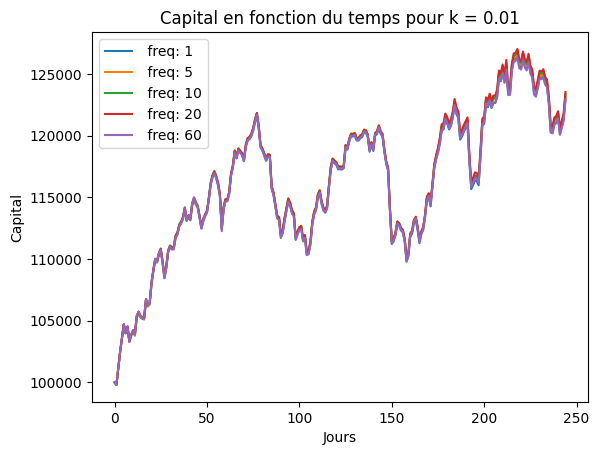

[np.float64(1960.5621199999998), np.float64(25.384269999999997), np.float64(11.259400000000001), np.float64(20.25288), np.float64(19.37565), np.float64(21.991750000000003), np.float64(11.631599999999999), np.float64(12.479600000000001), np.float64(19.523660000000003), np.float64(11.2429), np.float64(17.47755), np.float64(10.17585), np.float64(5.40125), np.float64(20.502000000000002), np.float64(3.5180000000000002), np.float64(4.4336), np.float64(12.101600000000001), np.float64(12.8067), np.float64(15.150299999999998), np.float64(7.3953500000000005), np.float64(43.36250000000001), np.float64(9.624699999999999), np.float64(24.368499999999994), np.float64(15.5705), np.float64(15.948800000000002), np.float64(15.130799999999999), np.float64(11.137150000000004), np.float64(10.4016), np.float64(8.824000000000002), np.float64(15.9415), np.float64(22.463649999999998), np.float64(14.825199999999997), np.float64(25.2283), np.float64(13.2315), np.float64(7.3252), np.float64(12.6314), np.float64(14

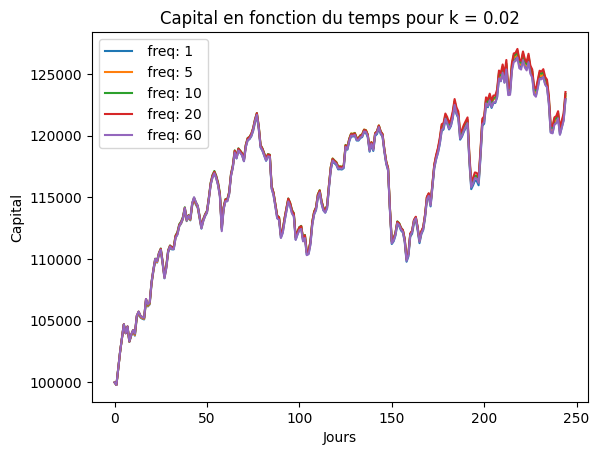

[np.float64(4759.755075), np.float64(64.63312499999999), np.float64(35.76574999999999), np.float64(47.109125000000006), np.float64(47.941), np.float64(63.70125000000001), np.float64(30.842249999999996), np.float64(31.199), np.float64(47.59975000000001), np.float64(26.986874999999998), np.float64(43.984525000000005), np.float64(28.16575), np.float64(16.267125), np.float64(47.562000000000005), np.float64(10.742750000000001), np.float64(24.597125000000002), np.float64(17.64275), np.float64(35.001749999999994), np.float64(40.342999999999996), np.float64(25.395375), np.float64(108.191375), np.float64(22.827624999999998), np.float64(61.84474999999999), np.float64(20.6585), np.float64(24.420625), np.float64(34.729499999999994), np.float64(25.27), np.float64(26.987750000000002), np.float64(29.65625), np.float64(58.79937500000001), np.float64(51.564750000000004), np.float64(33.6805), np.float64(59.328625), np.float64(29.004500000000004), np.float64(19.580625), np.float64(30.94575), np.float64(3

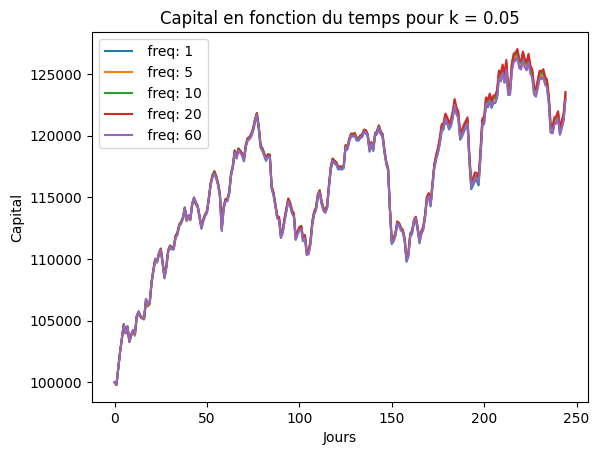

In [79]:
# initialiser le capital
C = 100000
S = [[] for _ in range(12)]  # liste vide pour stocker les prix des actions

for i in range(12):
    S[i] = [
        (BD2019[i].iloc[j, 3] + BD2019[i].iloc[j, 4]) / 2 for j in range(len(BD2019[i]))
    ]  # S[i] est la liste des prix de l'action i en 2019

ks = np.array([0, 0.01, 0.02, 0.05])
freqs = [1, 5, 10, 20, 60]
ks = np.round(ks, 3)

C_all = []
fees_all = []

for k in ks:
    for freq in freqs:
        Cs, fees = test_strategy_with_k(C, x_opt, S, k, freq)
        C_all.append(Cs)
        fees_all.append(fees)
        print(fees)
    for i in range(len(freqs)):
        plt.plot(C_all[i], label=" freq: " + str(freqs[i]))
    plt.xlabel("Jours")
    plt.ylabel("Capital")
    plt.title("Capital en fonction du temps pour k = " + str(k))
    plt.legend()
    plt.show()

## C. Appliquer la prix de transaction

**Soit** k un coût de transaction $$(k = \tfrac{S}{100}\bigr).(initial)$$

On définit la valeur du portefeuille après transaction à l’instant \(t\) comme :

$$
C_t \;=\; C \;-\; \mathrm{Cout_t}
$$

où le coût de transaction \(\mathrm{Cout}\_t\) s’écrit :

$$
\mathrm{Cout}_t
\;=\;
\sum_{i}
\Bigl|\theta_{\mathrm{ancienne}}^{\,i} \;-\; \theta_{\mathrm{nouveaux}}^{\,i}\Bigr|
\,\times\, S_t^i
\,\times\, k.
$$

---

**Projet :**

- $ k = \frac{S}{100} $ (faire varier …)
- $ f(\sigma*{\max}) $ : faire varier $\sigma*{\max}$
- Étude complète du problème : « Combien avez-vous gagné ? »
- Possibilité de choisir d’autres actions.


Never Balance/ once a month/a year
